# 3DVar with Lorenz’63
## Pavitra Chandarana, Jan Stüwe

In this notebook, we apply three‐dimensional variational data assimilation to the chaotic Lorenz’63 model using synthetic noisy observations. We enhance the classical 3DVar analysis with a neural‐network–based correction of the analysis increments and assess performance via RMSE and phase‐space diagnostics under different observational settings. Our results demonstrate the promise of hybrid variational–machine learning methods for improving state estimation in low‐dimensional chaotic systems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import plotly.graph_objects as go
import torch
from torch import nn

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

warnings. filterwarnings("ignore", category=Warning)                

The Lorenz ’63 system is a classic example of a low-dimensional chaotic dynamical system, governed by the equations:


\begin{aligned}
\dot{x} &= \sigma\,(y - x),\\
\dot{y} &= x\,(\rho - z) - y,\\
\dot{z} &= x\,y - \beta\,z,
\end{aligned}


where the parameters are set to $\sigma = 10, \rho = 28, \beta = \frac{8}{3}.
$

We will now:

1. Integrate the Lorenz equations from $t=0$ to $t=T$ using SciPy’s adaptive RK45 solver with a fixed maximum step size $\Delta t$.
2. Visualize the resulting 3D trajectory.

**Integration settings**:

- Time span: $0 \le t \le T$, with $T = 200$  
- Time step for output: $\Delta t = 0.01$
- Number of steps: $n_{\text{steps}} = T / \Delta t$  
- Initial condition: $\mathbf{x}_0 = [1.0,\,1.0,\,1.0]$

In [2]:
σ = 10.0    
ρ = 28.0    
β = 8.0 / 3.0 
dt = 0.01 

def lorenz63(x):
    """Vector field f(x) for the Lorenz-63 ODE."""
    x1, x2, x3 = x
    return np.array([
        σ * (x2 - x1),
        x1 * (ρ - x3) - x2,
        x1 * x2 - β * x3
    ])

def rk4_step(x, f, h):
    """One classical 4th-order Runge–Kutta step."""
    k1 = f(x)
    k2 = f(x + 0.5 * h * k1)
    k3 = f(x + 0.5 * h * k2)
    k4 = f(x + h * k3)
    return x + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def integrate(x0, n_steps, h=dt):
    """Integrate a single trajectory; returns array (n_steps+1, 3)."""
    xs = np.empty((n_steps + 1, 3))
    xs[0] = x0
    x = x0.copy()
    for i in range(1, n_steps + 1):
        x = rk4_step(x, lorenz63, h)
        xs[i] = x
    return xs

def batch_integrate(x0_batch, n_steps, h=dt):
    """Integrate many ICs in parallel; returns (n_ic, n_steps+1, 3)."""
    return np.stack([integrate(x0, n_steps, h) for x0 in x0_batch])

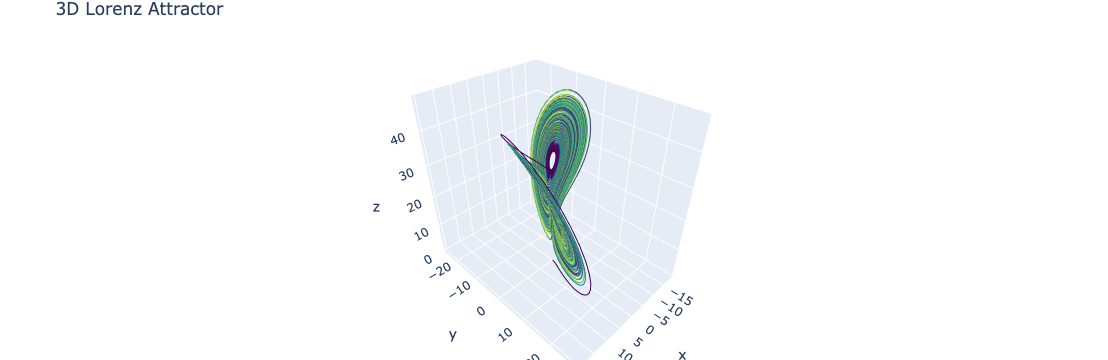

In [3]:
T = 200.0        
n_truth = int(T / dt)    
x0_truth = np.array([1.0, 1.0, 1.0]) 
org_time = np.linspace(0, 200, 20001)

truth = integrate(x0_truth, n_truth) 

stride = 2
obs_times_idx = np.arange(0, truth.shape[0], stride)
obs_times = obs_times_idx * dt

obs_noise_std = 1
H = np.eye(3)      # LINEAR OPERATOR H
y_obs = truth[obs_times_idx] + np.random.normal(0, obs_noise_std, size=(len(obs_times_idx), 3))

trace = go.Scatter3d(
    x=truth[:, 0], y=truth[:, 1], z=truth[:, 2],
    mode="lines",
    line=dict(
        width=2,
        color=org_time,
        colorscale="Viridis"
    )
)

layout = go.Layout(
    title="3D Lorenz Attractor",
    scene=dict(
        xaxis=dict(title="x"),
        yaxis=dict(title="y"),
        zaxis=dict(title="z"),
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

## Task 1: Compute RMSE between multiple Lorenz runs + Construction of $B$
We compute one "ground-truth" Lorenz'63 run. Afterwards we run 20 more, compute the RMSE to the groundtruth and take the mean.

In [4]:
N_ens = 10                           
x0_ens = np.random.uniform(-20, 20, size=(N_ens, 3)) 
free_runs = batch_integrate(x0_ens, n_truth)      

ens_mean = free_runs.mean(axis=0)                     
sq_err   = (free_runs - ens_mean[None, :, :])**2
rmse_t   = np.sqrt(sq_err.mean(axis=(0, 2)))        

X_prime = free_runs[:, -1, :] - free_runs[:, -1, :].mean(axis=0)
B = X_prime.T @ X_prime / (N_ens - 1)

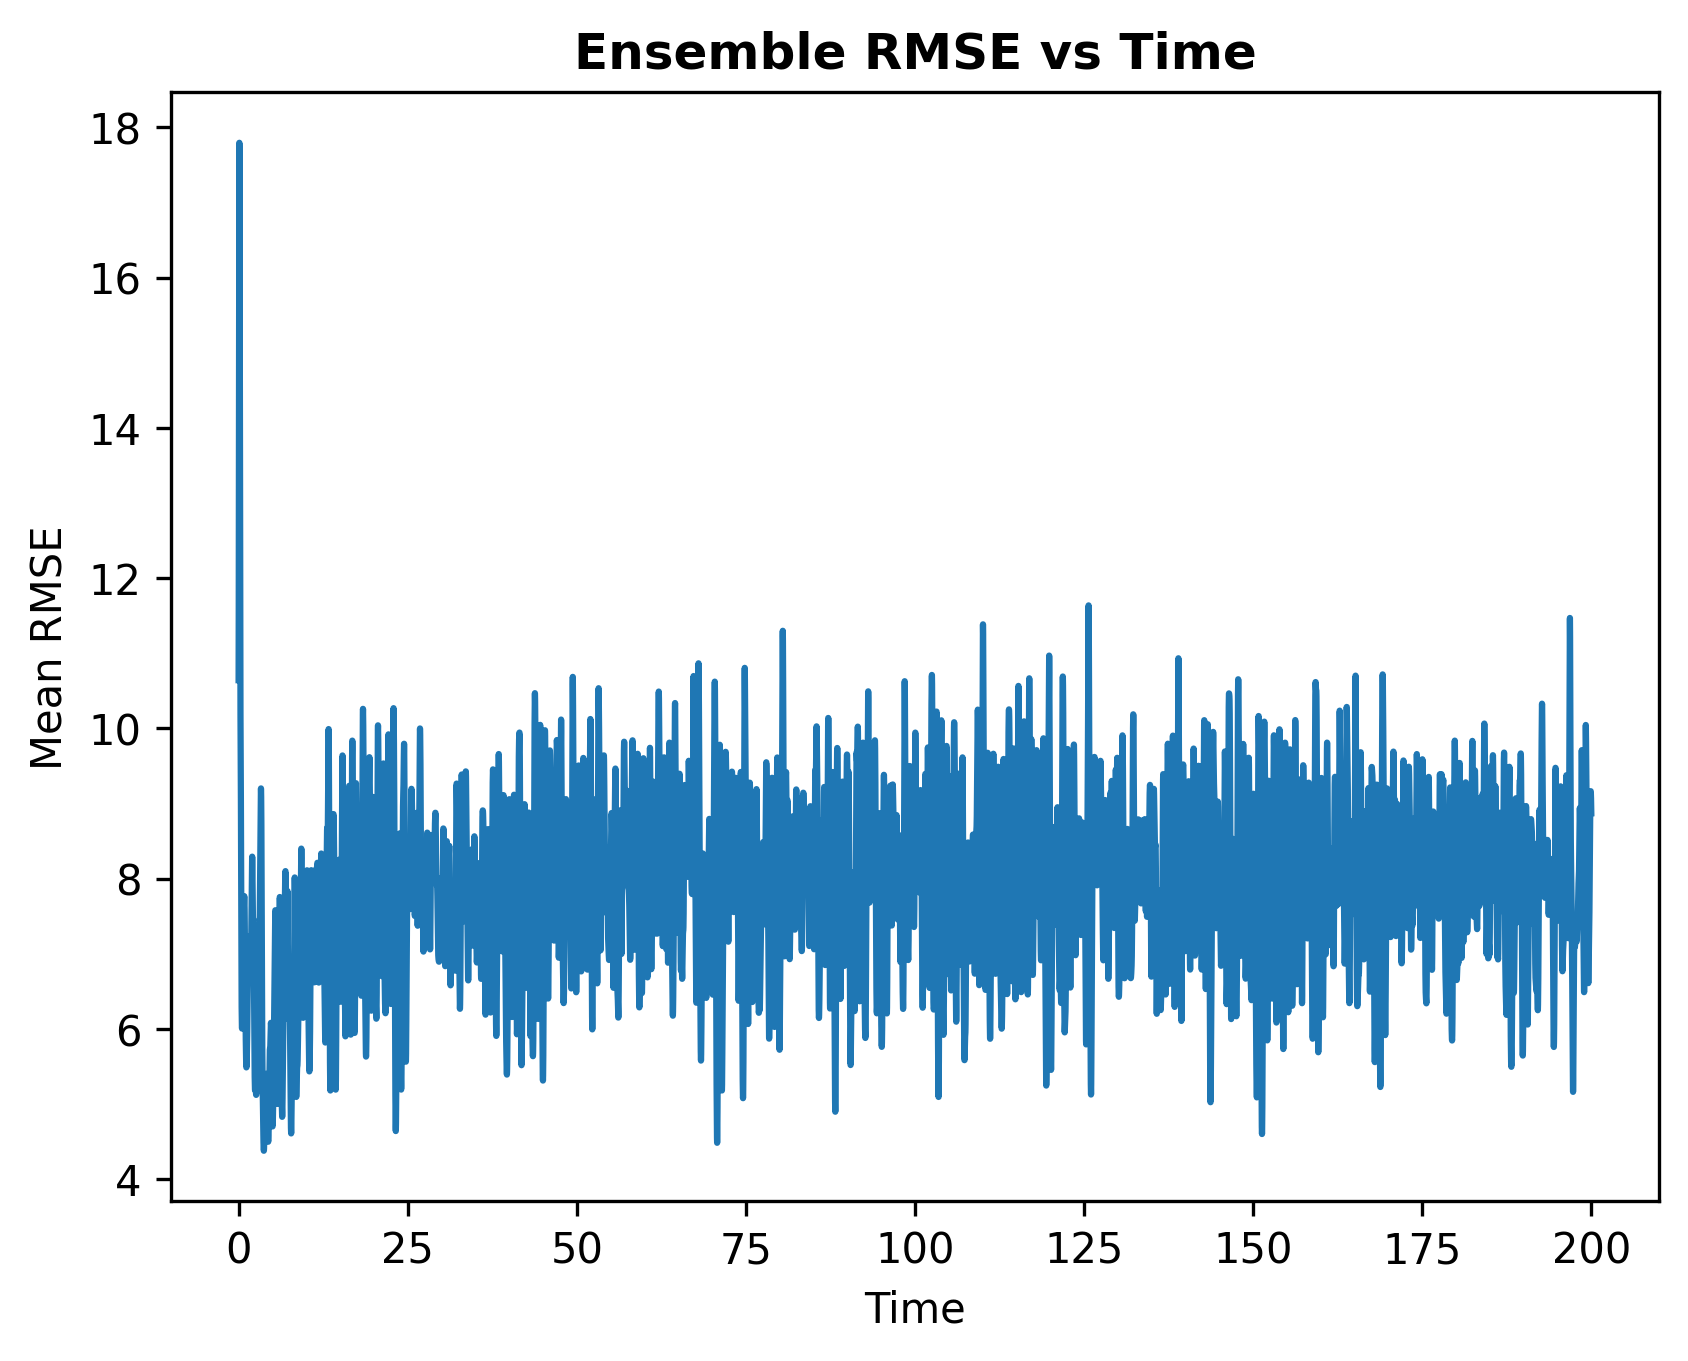

In [5]:
plt.figure(dpi=300)
plt.plot(org_time, rmse_t)
plt.xlabel("Time")
plt.ylabel("Mean RMSE")
plt.title("Ensemble RMSE vs Time", fontweight="bold")
plt.show()

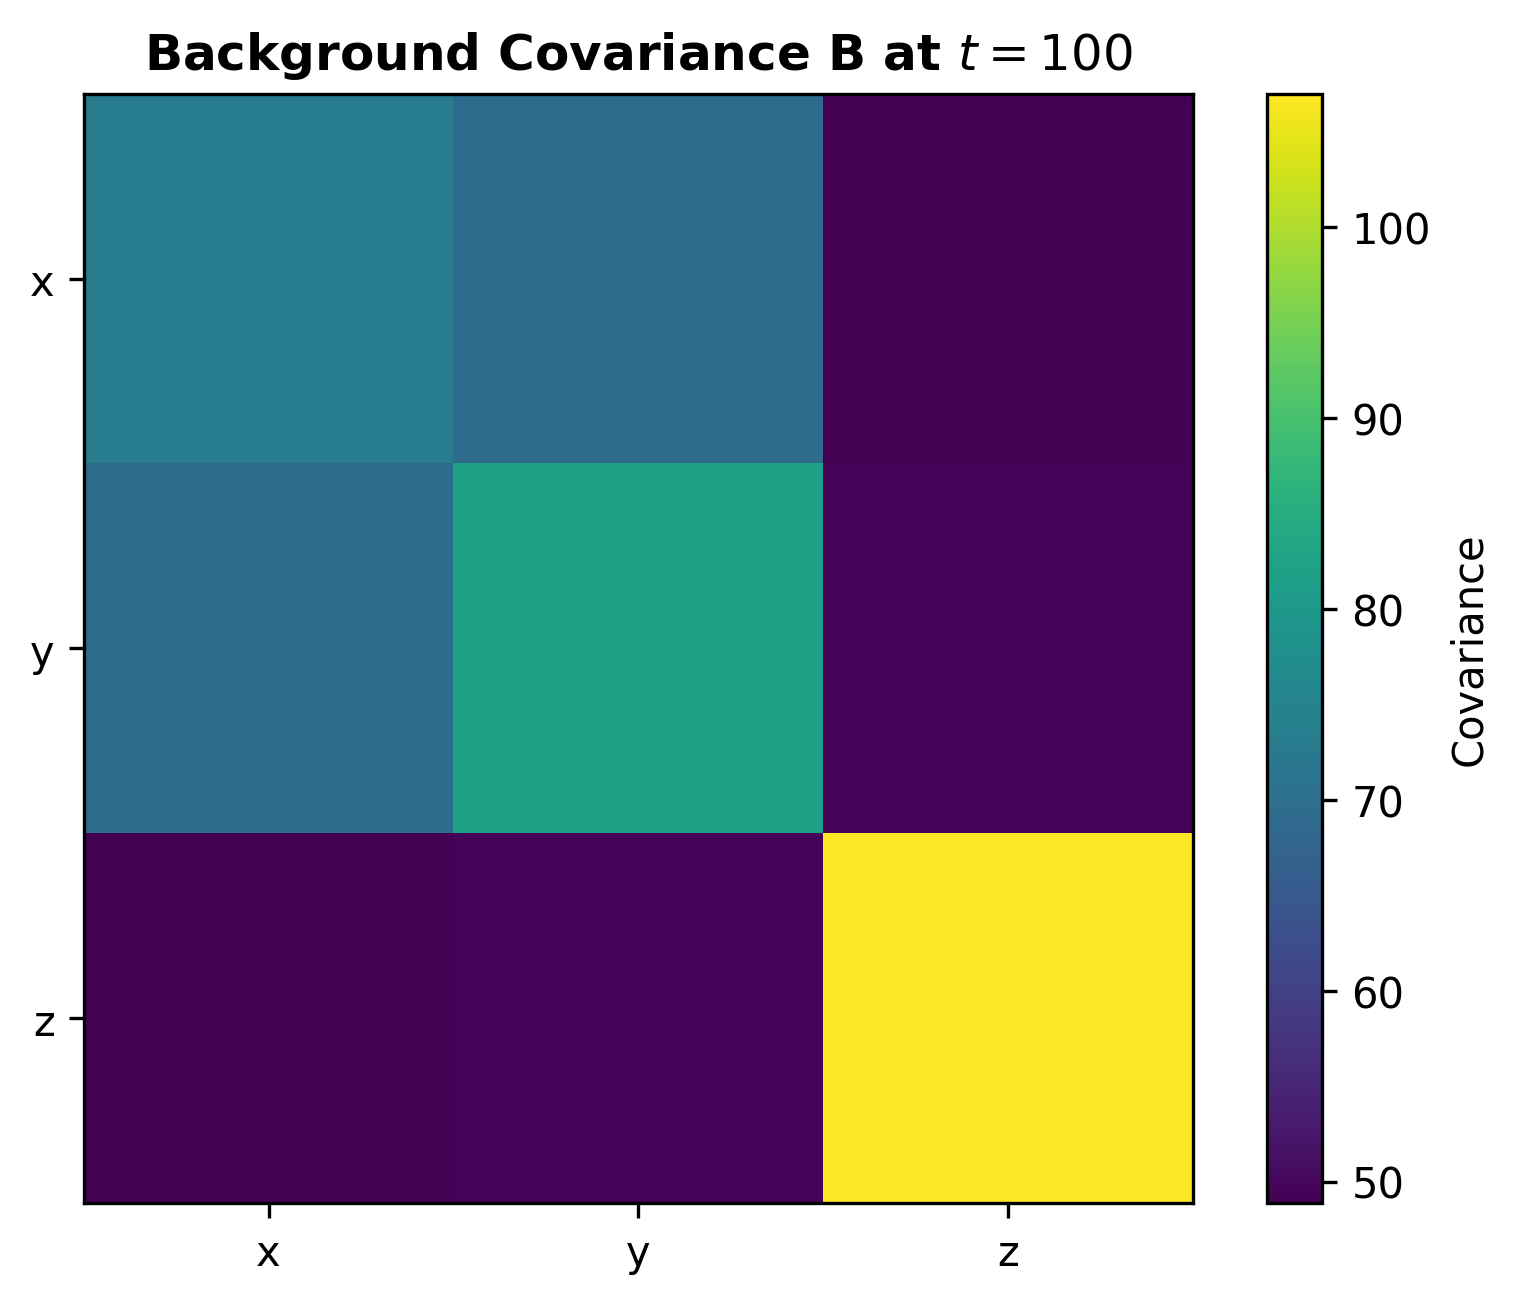

In [6]:
plt.figure(dpi=300)
plt.imshow(B, cmap="viridis", interpolation="none")
plt.colorbar(label="Covariance")
plt.title("Background Covariance B at $t=100$", fontweight="bold")
plt.xticks([0,1,2], ["x","y","z"])
plt.yticks([0,1,2], ["x","y","z"])
plt.show()

# Twin Experiment

In [7]:
R = (obs_noise_std**2) * np.eye(3)          # observation-error covariance
R_inv = np.linalg.inv(R)
K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)  # constant Kalman gain (static B)
print("3D-Var Kalman gain K:\n", K)

def assimilate_3dvar(x0_b, obs_times_idx, y_obs):
    """Return arrays of analysis and background trajectories."""
    x_b = x0_b.copy()
    x_b_series = []
    x_a_series = []
    innovations = []
    incs = []

    for k, obs_idx in enumerate(obs_times_idx):
        # Forecast from last analysis to current obs time
        steps_ahead = obs_idx - (0 if k == 0 else obs_times_idx[k-1])
        x_b = integrate(x_b, steps_ahead)[-1]

        # Innovation and analysis
        d = y_obs[k] - H @ x_b
        x_a = x_b + K @ d

        # Store
        innovations.append(d)
        incs.append(x_a - x_b)
        x_b_series.append(x_b.copy())
        x_a_series.append(x_a.copy())

        # Next cycle: start from analysis
        x_b = x_a

    return (np.array(x_b_series), np.array(x_a_series),
            np.array(innovations), np.array(incs))

x_b_series, x_a_series, d_series, inc_series = assimilate_3dvar(
    x0_b=np.array([-8.0, 7.0, 27.0]),    # deliberately wrong initial guess
    obs_times_idx=obs_times_idx,
    y_obs=y_obs
)

3D-Var Kalman gain K:
 [[0.93562799 0.05009556 0.00619925]
 [0.05009556 0.94446138 0.00275633]
 [0.00619925 0.00275633 0.98667049]]


In [13]:
train_frac = 0.8
n_cycles   = len(obs_times_idx)
n_train    = int(train_frac * n_cycles)

X_feat = np.hstack([
    x_b_series,    
    y_obs     
])                    

truth_at_obs = truth[obs_times_idx]    
y_target = truth_at_obs - x_b_series     

X_train = torch.tensor(X_feat[:n_train], dtype=torch.float32)
y_train = torch.tensor(y_target[:n_train], dtype=torch.float32)
X_val   = torch.tensor(X_feat[n_train:], dtype=torch.float32)
y_val   = torch.tensor(y_target[n_train:], dtype=torch.float32)

# ---- Model ------------------------------------------------------------------
mlp = nn.Sequential(
    nn.Linear(6, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, 32), nn.ReLU(),
    nn.Linear(32, 16), nn.ReLU(),
    nn.Linear(16, 3)
)

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()

best_val = float("inf")
patience = 50
wait     = 0

for epoch in range(1000):
    # -- training --
    mlp.train()
    optimizer.zero_grad()
    loss = loss_fn(mlp(X_train), y_train)
    loss.backward(); optimizer.step()

    # -- validation --
    mlp.eval()
    with torch.no_grad():
        val_loss = loss_fn(mlp(X_val), y_val).item()

    if val_loss < best_val - 1e-5:
        best_val = val_loss
        wait = 0
    else:
        wait += 1
        if wait > patience:
            print(f"Early-stopping at epoch {epoch}")
            break

print("Best validation MSE:", best_val)
mlp.eval()

Best validation MSE: 0.35749155282974243


Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16, out_features=3, bias=True)
)

In [19]:
w_blend = 0.5    # weight for ML increment in [0,1]
x_b  = np.array([-8.0, 7.0, 27.0])  # same bad start
hybrid_rmse = []

for k, obs_idx in enumerate(obs_times_idx):
    # Forecast
    steps_ahead = obs_idx - (0 if k == 0 else obs_times_idx[k-1])
    x_b = integrate(x_b, steps_ahead)[-1]

    # Innovation
    d = y_obs[k] - H @ x_b
    δ_3d = K @ d

    # ML increment
    feat = torch.tensor(np.hstack([x_b, y_obs[k]]), dtype=torch.float32)
    δ_ml = mlp(feat).detach().numpy()

    # Blended analysis
    x_a = x_b + δ_3d + w_blend * δ_ml

    # Skill metric
    err = np.linalg.norm(x_a - truth[obs_idx])
    hybrid_rmse.append(err)

    # next cycle
    x_b = x_a

print("Hybrid mean RMSE:", np.mean(hybrid_rmse))

Hybrid mean RMSE: 1.8790928086349965


In [15]:
# ---- Section 7 : innovation mean & covariance --------------------------------
d_mat = np.array(d_series)            # (n_cycles, 3)
d_mean = d_mat.mean(axis=0)
print("Mean innovation μ_d:", d_mean)

S_hat = (d_mat - d_mean).T @ (d_mat - d_mean) / (d_mat.shape[0] - 1)
S_theo = H @ B @ H.T + R
print("\nSample innovation cov  Ŝ:\n", S_hat)
print("\nTheoretical S = HBHᵀ + R:\n", S_theo)

fro_norm = np.linalg.norm(S_hat - S_theo, ord='fro')
print("\nFrobenius norm |Ŝ - S|_F =", fro_norm)

Mean innovation μ_d: [-0.00057254  0.00303482 -0.00096504]

Sample innovation cov  Ŝ:
 [[ 1.67853369  0.25785282 -0.04646273]
 [ 0.25785282  1.91510164  0.03228879]
 [-0.04646273  0.03228879  1.95521108]]

Theoretical S = HBHᵀ + R:
 [[ 74.25012215  69.39923618  48.88269504]
 [ 69.39923618  83.05745192  49.45096249]
 [ 48.88269504  49.45096249 107.98142754]]

Frobenius norm |Ŝ - S|_F = 205.7325263805216


In [22]:
w_blend = 0.5    # weight for ML increment in [0,1]
x_b  = np.array([-8.0, 7.0, 27.0])  # same bad start
rmse_ml = []
rmse_3d = []

for k, obs_idx in enumerate(obs_times_idx):
    # Forecast
    steps_ahead = obs_idx - (0 if k == 0 else obs_times_idx[k-1])
    x_b = integrate(x_b, steps_ahead)[-1]

    # Innovation
    d = y_obs[k] - H @ x_b
    δ_3d = K @ d

    # ML increment
    feat = torch.tensor(np.hstack([x_b, y_obs[k]]), dtype=torch.float32)
    δ_ml = mlp(feat).detach().numpy()

    # Blended analysis
    x_a_3d = x_b + δ_3d
    x_a_ml = x_b + δ_ml

    # Skill metric
    err = np.linalg.norm(x_a_3d - truth[obs_idx])
    rmse_3d.append(err)

    err = np.linalg.norm(x_a_ml - truth[obs_idx])
    rmse_ml.append(err)
    
    # next cycle
    x_b = x_a_ml

print("ML mean RMSE:", np.mean(rmse_ml))
print("3D mean RMSE:", np.mean(rmse_3d))

ML mean RMSE: 0.7724048408303518
3D mean RMSE: 1.523806587353293


In [27]:
# ---------- Cell A : helper + gain functions ---------------------------------
from typing import Callable, Dict

def run_cycle(x0: np.ndarray,
              gain: Callable[[np.ndarray, np.ndarray], np.ndarray],
              label: str) -> Dict[str, np.ndarray]:
    """
    Forecast–analysis loop using a user-supplied gain rule.

    Returns a dict with keys: 'label', 'rmse', 'x_b', 'x_a'.
    """
    x_b  = x0.copy()
    b_hist, a_hist, rmse_hist = [], [], []

    for k, idx in enumerate(obs_times_idx):
        # 1️⃣ forecast from last analysis to current obs time
        steps = idx - (0 if k == 0 else obs_times_idx[k-1])
        x_b   = integrate(x_b, steps)[-1]

        # 2️⃣ analysis via chosen gain
        x_a   = gain(x_b, y_obs[k])

        # 3️⃣ bookkeeping
        b_hist.append(x_b)
        a_hist.append(x_a)
        rmse_hist.append(np.linalg.norm(x_a - truth[idx]))  # Euclidean error

        x_b = x_a  # next cycle starts from analysis

    return {"label": label,
            "x_b":  np.vstack(b_hist),
            "x_a":  np.vstack(a_hist),
            "rmse": np.array(rmse_hist)}


# ----- classic 3D-Var gain ----------------------------------------------------
def classic_gain(x_b, y_k):
    d = y_k - H @ x_b            # innovation
    return x_b + K @ d           # x_a = x_b + K d


# ----- predicted-increment gain ----------------------------------------------
def ml_gain(x_b, y_k):
    feat  = torch.tensor(np.hstack([x_b, y_k]), dtype=torch.float32)
    δ_ml  = mlp(feat).detach().numpy()        # neural-net increment
    return x_b + δ_ml                         # x_a = x_b + δ̂_ml

        Method  Mean RMSE  Median RMSE  Min (best)
        3D-Var     1.5251       1.4706      0.0109
Predicted-Incr     0.7724       0.7295      0.0406


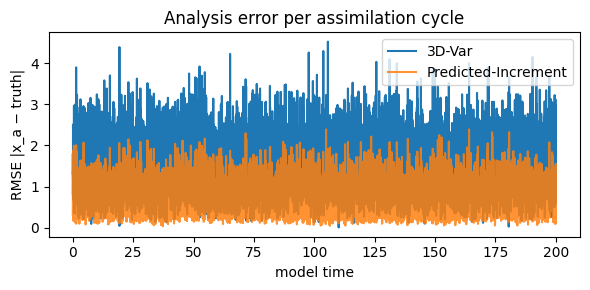

In [29]:
# ---------- Cell B : execute cycles & compare --------------------------------
x0_bad = np.array([-8.0, 7.0, 27.0])      # same poor starting guess

standard  = run_cycle(x0_bad, classic_gain, label="3D-Var")
pred_inc  = run_cycle(x0_bad, ml_gain    , label="Predicted-Incr")

# ---- 1️⃣ headline stats ------------------------------------------------------
import pandas as pd
summary = pd.DataFrame({
    "Method":        [standard["label"], pred_inc["label"]],
    "Mean RMSE":     [standard["rmse"].mean(), pred_inc["rmse"].mean()],
    "Median RMSE":   [np.median(standard["rmse"]), np.median(pred_inc["rmse"])],
    "Min (best)":    [standard["rmse"].min(), pred_inc["rmse"].min()]
})
print(summary.to_string(index=False, float_format="%.4f"))

# ---- 2️⃣ RMSE time-series plot ----------------------------------------------
import matplotlib.pyplot as plt
t = obs_times_idx * dt
plt.figure(figsize=(6,3))
plt.plot(t, standard["rmse"], label="3D-Var")
plt.plot(t, pred_inc["rmse"], label="Predicted-Increment", alpha=0.85)
plt.xlabel("model time"); plt.ylabel("RMSE |x_a − truth|")
plt.title("Analysis error per assimilation cycle")
plt.legend(); plt.tight_layout()
plt.show()